Nama : Aryo Adi Putro
Kelas : TI 3G
NIM : 2341720084
Absen : 07

# Tugas Praktikum - Nomor 1
Klasifikasi Gender Voice menggunakan SVM dengan berbagai kernel dan rasio split.

## Langkah 1 - Import Library

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Langkah 2 - Load Dataset

In [33]:
file_path = '/content/drive/MyDrive/Machine Learning - 2025/Jobsheet-11/dataset/voice.csv'

df = pd.read_csv(file_path)
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


## Langkah 3 - Memisahkan Fitur dan Label + Label Encoding

In [34]:
X = df.drop('label', axis=1)
y = df['label']

le = LabelEncoder()
y = le.fit_transform(y)  # male=1, female=0

## Langkah 4 - Standarisasi Fitur

In [35]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Langkah 5 - Fungsi Evaluasi Model SVM

In [36]:
def evaluate_svm(test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

## Langkah 6 - Evaluasi Model Berdasarkan Split dan Kernel

In [37]:
results = []
splits = [(0.30, "70:30"), (0.20, "80:20")]
kernels = ["linear", "poly", "rbf"]

for test_size, split_label in splits:
    for k in kernels:
        acc = evaluate_svm(test_size, k)
        results.append([split_label, k, round(acc, 4)])

results_df = pd.DataFrame(results, columns=["Split", "Kernel", "Accuracy"])
results_df

,Split,Kernel,Accuracy
0,70:30,linear,0.9790
1,70:30,poly,0.9590
2,70:30,rbf,0.9832
3,80:20,linear,0.9748
4,80:20,poly,0.9574
5,80:20,rbf,0.9826


## Langkah 7 - Visualisasi Perbandingan Akurasi

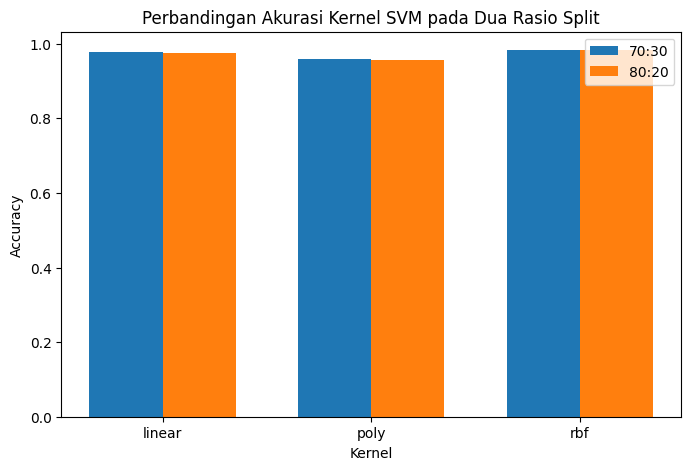

In [38]:
plt.figure(figsize=(8,5))

kernels = ["linear", "poly", "rbf"]
acc_70 = results_df[results_df["Split"]=="70:30"]["Accuracy"].values
acc_80 = results_df[results_df["Split"]=="80:20"]["Accuracy"].values

x = np.arange(len(kernels))
width = 0.35

plt.bar(x - width/2, acc_70, width, label="70:30")
plt.bar(x + width/2, acc_80, width, label="80:20")

plt.xticks(x, kernels)
plt.ylabel("Accuracy")
plt.xlabel("Kernel")
plt.title("Perbandingan Akurasi Kernel SVM pada Dua Rasio Split")
plt.legend()
plt.show()

Berdasarkan hasil pengujian pada dataset `voice.csv`, seluruh kernel SVM memberikan akurasi yang tinggi (sekitar **95%-98%**), yang menunjukkan bahwa fitur suara pada dataset memiliki pemisahan kelas yang jelas antara laki-laki dan perempuan. Namun, kernel RBF consistently menghasilkan akurasi tertinggi pada kedua skenario pembagian data 70:30 maupun 80:20, sehingga dapat disimpulkan bahwa SVM dengan kernel RBF merupakan model yang paling optimal untuk dataset ini.

# Tugas Praktikum - Nomor 2
Klasifikasi Citra Siang dan Malam menggunakan SVM dengan Fitur Histogram (Kernel RBF)

## Langkah 1 - Import Library

In [39]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Langkah 2 - Menentukan Path Dataset

In [41]:
root = Path("/content/drive/MyDrive/Machine Learning - 2025/Jobsheet-11/images/")

## Langkah 3 - Fungsi Load Gambar & Ekstraksi Fitur Histogram (Channel V HSV)

In [42]:
def load_images_and_labels(root):
    data = []
    for folder in ["training/day", "training/night", "tes/day", "tes/night"]:
        label = 1 if "day" in folder else 0
        for img_path in (root / folder).glob("*.jpg"):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (100, 100))
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            hist = cv2.calcHist([hsv], [2], None, [256], [0,256]).flatten()
            data.append((hist, label))
    return data

dataset = load_images_and_labels(root)
len(dataset)

240

## Langkah 4 - Memisahkan Fitur dan Label serta Melakukan Train-Test Split (80:20)

In [43]:
X = np.array([d[0] for d in dataset])
y = np.array([d[1] for d in dataset])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((192, 256), (48, 256))

## Langkah 5 - Hyperparameter Tuning SVM RBF

In [44]:
results = []

C_values = [1, 10, 100]
gamma_values = [0.1, 0.01, 0.001]

for C in C_values:
    for gamma in gamma_values:
        model = SVC(kernel='rbf', C=C, gamma=gamma)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append([C, gamma, round(acc, 4)])

results_df = pd.DataFrame(results, columns=["C", "gamma", "Accuracy"])
results_df

,C,gamma,Accuracy
0,1,0.100,0.5000
1,1,0.010,0.8333
2,1,0.001,0.5625
3,10,0.100,0.5000
4,10,0.010,0.8333
5,10,0.001,0.6042
6,100,0.100,0.5000
7,100,0.010,0.8333
8,100,0.001,0.6042


## Langkah 6 - Visualisasi Hasil dalam Heatmap

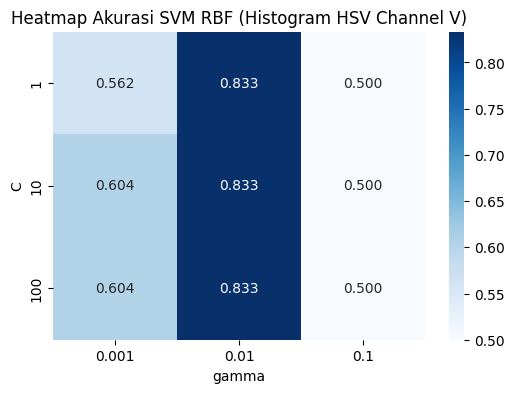

In [45]:
pivot_table = results_df.pivot(index="C", columns="gamma", values="Accuracy")

plt.figure(figsize=(6,4))
sns.heatmap(pivot_table, annot=True, cmap="Blues", fmt=".3f")
plt.title("Heatmap Akurasi SVM RBF (Histogram HSV Channel V)")
plt.show()

Pada klasifikasi citra siang dan malam menggunakan fitur histogram channel V (HSV) dan SVM kernel RBF dengan pembagian data **80:20**, diperoleh hasil bahwa kombinasi parameter **C = 1, 10, maupun 100** dengan **gamma = 0.01** menghasilkan akurasi tertinggi sebesar 0.8333. Sementara nilai gamma lainnya menunjukkan akurasi lebih rendah (sekitar **0.50-0.60**). Hal ini menunjukkan bahwa nilai gamma lebih berpengaruh dibandingkan nilai C dalam model ini, dan bahwa pemilihan hyperparameter yang tepat sangat menentukan performa klasifikasi.